#Final assignment: write a maze solver
For your final assignment you are asked to write a maze solver. You will be given 4 (four) mazes to try your solver on. The mazes that you need to solve will be rectangular, with corridors that are either horizontal or vertical. Also, only two openings exist at the edge of the maze. You should start from one of these openings and find the other one.

**We will test your maze solver with a fifth maze whose structure you don't know!**

---
### Student names
Ernani Hazbolatow and Esra de Bruin. The work was done together and therefore the specific parts of the code cannot be allocated to a single individual.


---
### ChatGPT
One of us has previously had to apply BFS on a similar type of problem (in that instance, it was about a Roomba navigating a floor plan). We had to search the pseudocode for BFS. Normally, such an algorithm is done on a graph object. Instead, we directly worked on the grid. So, we also looked up some minor details on that conversion from graph to grid. 

We asked ChatGPT to generate a handful of extra mazes as well as perform a final code check against the assignment requirements so nothing was done out of that would cost us marks.

---
### Overall structure of the graded assignment

The work can be broken up into two parts:


1.   Write a function that plots the maze
3.   Write a function that finds the path through the maze

It is recommended you do these parts in order. The reason is that being able to plot the maze will help you debug the other part.

Your assignment will be graded based on several things:


1.   A working code that does what it is supposed to do
2.   A readable code. This means both a clean structure
 (i.e. no spaghetti code) and plenty of comments
3.   Your answers during the interview

More details will be provided below.

We have provided a function that finds the openings of the maze. You should use this function. You should also understand how this function works because we will ask questions about it during the interview.

This graded assignments counts for 25 points to the total of 100 points for this course. To pass the course, you need to pass this assignment with at least 13 points.





---
### Loading packages
The first thing you need to do is to import packages that you will need for your code. Use a single cell to import these packages.


In [ ]:
import pickle
import random
import os
import numpy as np
from typing import List, Tuple, Deque, Dict, Optional
from collections import deque
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from pathlib import Path

---
### Mounting your Google drive and changing to your working directory
Please make sure you change into the right directory (where you have your maze files).

In [5]:
#from google.colab import drive
#drive.mount('/content/drive')

#%cd drive/MyDrive/



---

Now you will want to jump ahead to the last cells in this notebook, and write a few lines of code to read a particular maze. Having such data loaded will make writing (and debugging) Part 1 and 2 easier.

---
### Part 1: Define a function to plot the maze
In the cell below, write a function that plots the maze. As an example, see the slides from lecture 6. The plot should show at least:

1.   The walls and corridors
2.   The path of the agent
3.   The start and finish should be highlighted, either through colour or symbols

Notice that this functions requires two (and only two) arguments:

1.   a 2D array that defines the maze
2.   a list that defines the path

This function does not need a return. Your function should be well commented: the function itself, the most important variables, and the most important parts of the function body.

In [15]:
# This code was previously made first for the class, so we pulled it out as an independent function/
def plot_path(
    maze: np.ndarray,
    path_coords
):
    num_rows, num_cols = maze.shape


    # Infer start and goal from path
    start = path_coords[0]
    goal = path_coords[-1]

    # Create base visualization array (0=Wall, 1=Free, 2=Path, 3=Start/Goal)
    plot_array = np.zeros(maze.shape, dtype=int)

    # Free space (where maze is True) is marked as 1, 0 is wall
    plot_array[maze.astype(bool)] = 1

    # Mark the path
    r_path, c_path = zip(*path_coords)
    plot_array[r_path, c_path] = 2

    # Mark Start and Goal (highest priority: 3)
    plot_array[start] = 3
    plot_array[goal] = 3

    # Custom colors for the four values (0, 1, 2, 3)
    colors = ['#111827', '#E5E7EB', '#3B82F6', '#FBBF24']
    cmap = ListedColormap(colors)

    fig, ax = plt.subplots(figsize=(num_cols / 5, num_rows / 5), dpi=150)

    ax.imshow(plot_array, cmap=cmap)

    # Remove tick labels and borders for a cleaner look
    ax.set_xticks([])
    ax.set_yticks([])
    ax.tick_params(axis='both', which='both', length=0)
    ax.set_frame_on(False)

    # Text labels for Start and Goal
    ax.text(start[1], start[0], 'S', ha='center', va='center',
            color='black', fontsize=12)
    ax.text(goal[1], goal[0], 'G', ha='center', va='center',
            color='black', fontsize=12)

    path_len = len(path_coords)
    title = f"Maze Solution (Path Length: {path_len})"
    ax.set_title(title, fontsize=max(10, num_cols / 2))

    plt.show()


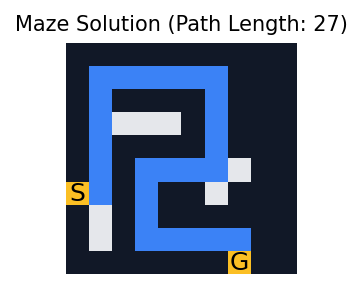

In [ ]:
with open("mazes/maze10x10.pckl", "rb") as f:
    maze = pickle.load(f)

# You'll have to run Solver first to get the path 
solver = MazeSolver(maze)
plot_path(maze=maze, path_coords=solver.path())

---
### Define a function to find the openings

In the cell below, we define a function that finds the openings in a maze. Your should use this function. You may not change it.

During the interview, you will be questioned about this function. We have removed any comments from this function on purpose.

The function random.sample(x,2) randomly selects, without repetition, 2 elements from the list called x.


In [8]:
def findOpenings(maze):

  import random

  x = []
  nr,nc = maze.shape
  for ir in range(nr):
      if (maze[ir,0]):
          x.append([ir,0])
      if (maze[ir,nc-1]):
          x.append([ir,nc-1])
  for ic in range(nc):
      if (maze[0,ic]):
          x.append([0,ic])
      if (maze[nr-1,ic]):
          x.append([nr-1,ic])

  return random.sample(x,2)



---
### Part 2: Define a function that solves the maze

Here you can write a function that solves the maze, i.e. finds a path from the start to the finish. The function takes a single argument: a 2D array that defines the maze. It will need no return because "everything" will happen inside this function. This function should call the functions defined before.

You are free to use any method to solve the maze. You will not be graded for finding the shortest path, or finding the path the quickest. However, if your path contains loops (i.e. it crosses itself) we will deduct 2 points (out of 25).

Your function should be well commented: the function itself, the most important variables, and the most important parts of the function body.


In [9]:
# Coord data object: (nrow, ncol)
Coord = Tuple[int, int]

class MazeSolver:
    DIRECTIONS: Tuple[Coord, ...]= ((1, 0), (-1, 0), (0, 1), (0, -1)) # up, down, left, right (van moore)

    def __init__(self, maze: np.ndarray):
        # Save maze and its shape
        self.maze = maze
        self.num_rows, self.num_cols = self.maze.shape

        # We obtain goal by using findOpenings
        openings = findOpenings(self.maze)
        (sr, sc), (gr, gc) = openings
        self.start: Coord = (sr, sc)
        self.goal:  Coord = (gr, gc)

        # Stores the predecessor node for path reconstruction
        self.parent: Dict[Coord, Optional[Coord]] = {}

        # run the BFS algorithm to generate tree
        self.bfs()

    def is_free(self, row: int, col: int):
        return (
            0 <= row < self.num_rows and  # are we within row bounds?
            0 <= col < self.num_cols and # are we within col bounds?
            self.maze[row, col]   # maze is a boolean array, so True says we're open
            )
    
    def bfs(self):
        queue: Deque[Coord] = deque([self.start]) # the queue should start with the entrance
        self.parent = {self.start: None} # start cannot have parents (top of the tree)

        goal_found = False

        while queue:
            row, col = queue.popleft()
        
            if (row, col) == self.goal: # exit condition of while loop is when we find the goal
                goal_found = True
                break
            # we construct a tree
            for delta_row, delta_col in self.DIRECTIONS: # van neumann neighbourhood
                next_row, next_col = row + delta_row, col + delta_col # gives us option chain for our next step
                neighbor = (next_row, next_col)

                if self.is_free(next_row, next_col) and neighbor not in self.parent: #we shouldn't go back up and it should be free
                    self.parent[neighbor] = (row, col)
                    queue.append(neighbor)
            
        if not goal_found and self.goal in self.parent: # if a goal cannot be found, probably the goal is the parent
            del self.parent[self.goal]

    def path(self):
        if self.goal not in self.parent:
            return None # Path not found
            
        p: List[Coord] = []
        cur: Optional[Coord] = self.goal
        
        while cur is not None: # traverse parent
            p.append(cur)
            cur = self.parent[cur]
        return p[::-1] # Reverse to get path from start to goal

    def plot_path(self):
        path_coords = self.path()
        
        # create the base visualization array (0=Wall, 1=Free, 2=Path, 3=Start/Goal)
        plot_array = np.zeros(self.maze.shape, dtype=int)
        
        # free space (where maze is True) is marked as 1, 0 is wall
        plot_array[self.maze] = 1 
        
        # 2. Mark the Path
        if path_coords:
            # Mark the path points as 2
            r_path, c_path = zip(*path_coords)
            plot_array[r_path, c_path] = 2

        # Mark Start and Goal (Highest priority: 3)
        plot_array[self.start] = 3
        plot_array[self.goal] = 3

        # Custom colors for the four values (0, 1, 2, 3)
        colors = ['#111827', '#E5E7EB', '#3B82F6', '#FBBF24']
        cmap = ListedColormap(colors)

        fig, ax = plt.subplots(figsize=(self.num_cols / 5, self.num_rows / 5), dpi = 150) # size scales with maze

        # Display the array as an image
        ax.imshow(plot_array, cmap=cmap)

        # Remove tick labels and borders for a cleaner look
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.tick_params(axis='both', which='both', length=0)
        ax.set_frame_on(False)
        
        # text labels for Start and Goal
        ax.text(self.start[1], self.start[0], 'S', ha='center', va='center', color='black', fontsize=12)
        ax.text(self.goal[1], self.goal[0], 'G', ha='center', va='center', color='black', fontsize=12)

        path_len = len(path_coords)

        plt.savefig(f"solved/{self.num_rows}x{self.num_cols}sol.png", dpi=300, bbox_inches="tight")
        title = f"Maze Solution (Path Length: {path_len})"
        ax.set_title(title, fontsize=self.num_cols / 2)
        plt.tight_layout()
        plt.show()




---
### Main code
In your main code, you specify the maze you want to load, and actually load it. Furthermore, you will call the function that solves the maze. Your main code should be your last cell, because it will use the functions that you have defined above. For now, you have not yet defined any functions, but you still need to load your maze. Write down the code below.

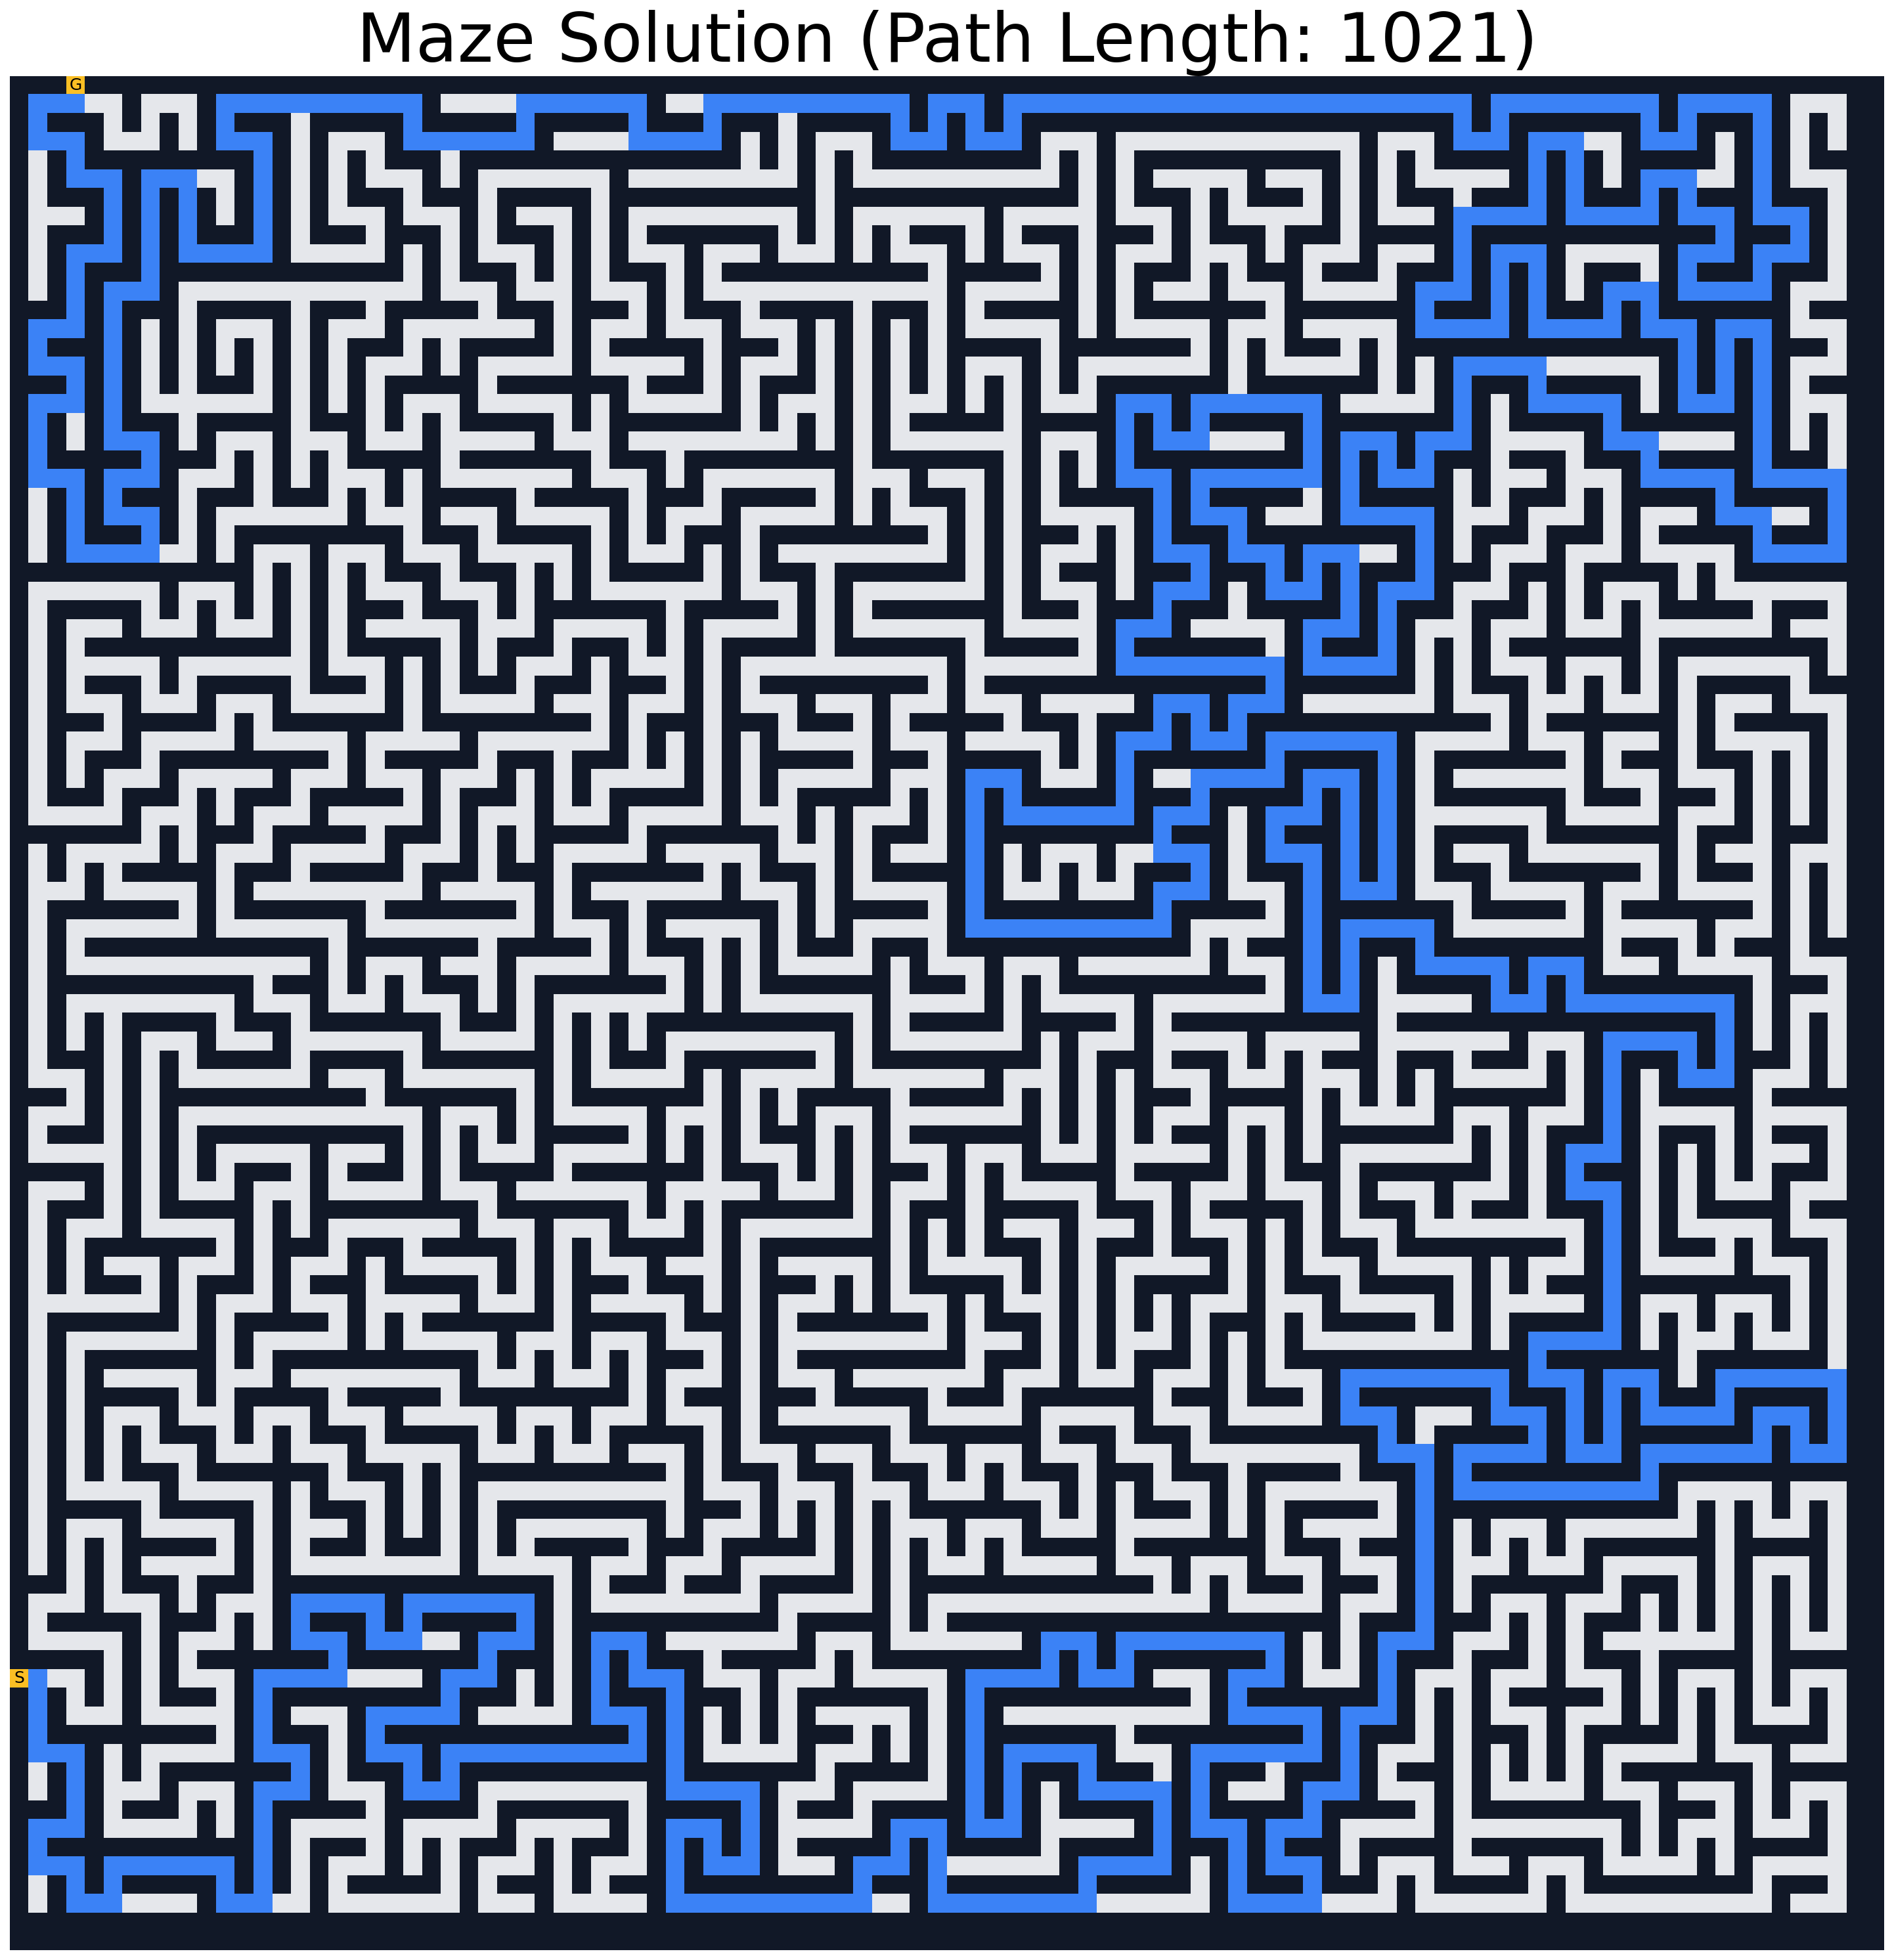

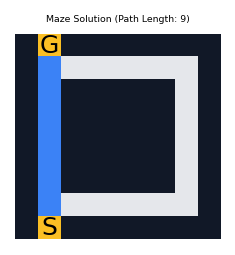

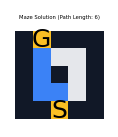

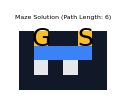

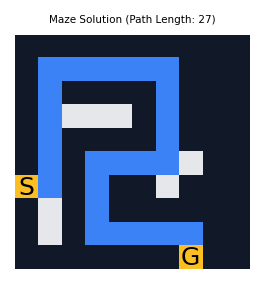

In [10]:

folder = Path("mazes")
out_dir = Path("solved")
out_dir.mkdir(exist_ok=True)

for file in folder.glob("*"):
    if not file.suffix.lower() in (".pkl", ".pckl"):
        continue

    with open(file, "rb") as f:
        maze = pickle.load(f)
        solve = MazeSolver(maze)
        solve.plot_path()